In [1]:
import numpy as np

#database handling
import pandas as pd

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#scientific calc
import astropy
from astropy.io.votable import parse
from astropy import units as u
from astropy.coordinates import SkyCoord

import scipy 
from scipy.optimize import minimize

import sympy

## data import

In [2]:
from astroquery.vizier import Vizier


VizOC_table2 = Vizier(catalog="J/A+A/659/A59/table2")
VizOC_table1 = Vizier(catalog="J/A+A/659/A59/table1")
VizOC_table2.ROW_LIMIT = -1

cluster = "Blanco_1"
OC_df = VizOC_table2.query_constraints(Cluster=cluster).values()[0].to_pandas()
OC_tb1_df = VizOC_table1.query_constraints(Cluster=cluster).values()[0].to_pandas()

## building density profile

Text(0, 0.5, 'pmdec')

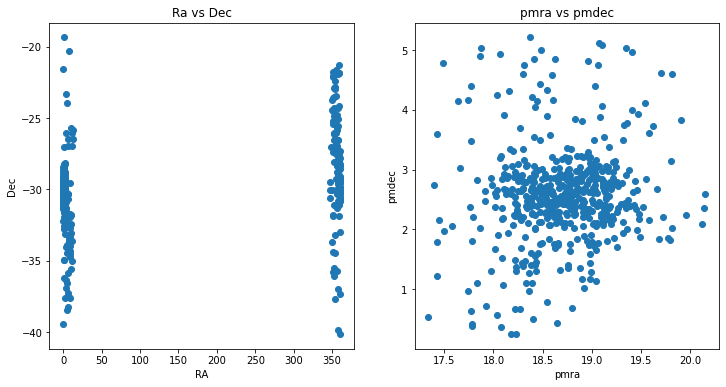

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(OC_df['RA_ICRS'], OC_df['DE_ICRS'], label='Blanco_1')
ax[1].scatter(OC_df['pmRA'], OC_df['pmDE'], label='Blanco_1')

ax[0].set_title('Ra vs Dec')
ax[1].set_title('pmra vs pmdec')

ax[0].set_xlabel('RA')
ax[0].set_ylabel('Dec')

ax[1].set_xlabel('pmra')
ax[1].set_ylabel('pmdec')

In [4]:
#getting and converting cluster members' eq coords to cartesian
blanco_1_eq_coords = SkyCoord(ra=OC_df['RA_ICRS'] * u.degree,
                              dec=OC_df['DE_ICRS'] * u.degree, 
                              distance=(1000 / OC_df['plx']) * u.Parcsec, frame='icrs')
blanco_1_cart_coords = blanco_1_eq_coords.cartesian.x, blanco_1_eq_coords.cartesian.y, blanco_1_eq_coords.cartesian.z


#getting and converting the center coords 
blanco_1_eq_center_coords = SkyCoord(ra=OC_tb1_df['RA_ICRS'] * u.degree, 
                                     dec=OC_tb1_df['DE_ICRS'] * u.degree, 
                                     distance=(1000/OC_tb1_df['plx']) * u.Parcsec, frame='icrs')
blanco_1_cart_center_coords = blanco_1_eq_center_coords.cartesian.x, blanco_1_eq_center_coords.cartesian.y, blanco_1_eq_center_coords.cartesian.z

#getting the distance of stars from the center of clusters
def dist(x1, y1, x2, y2):
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

d = dist(blanco_1_cart_center_coords[0], blanco_1_cart_center_coords[1],
         blanco_1_cart_coords[0], blanco_1_cart_coords[1])

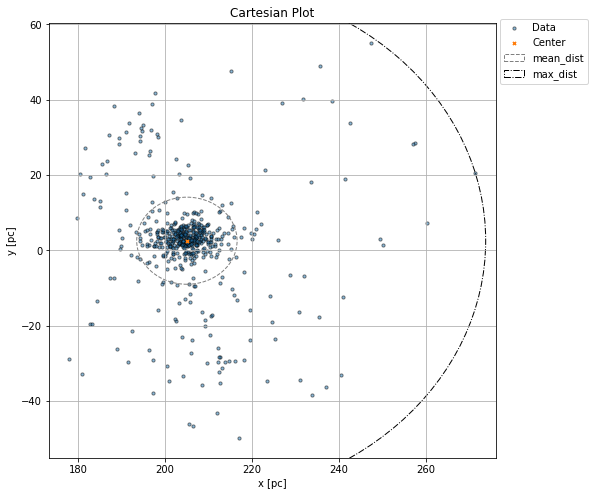

In [5]:
#plotting the cluster with radius regions
plt.figure(figsize=(8, 8))
plt.scatter(blanco_1_cart_coords[0], blanco_1_cart_coords[1], label='Data', s=10, alpha=0.5, edgecolors='k')
plt.scatter(blanco_1_cart_center_coords[0], blanco_1_cart_center_coords[1], label='Center', marker='x', s=10)

ax = plt.gca()
c_max = plt.Circle((blanco_1_cart_center_coords[0].value,blanco_1_cart_center_coords[1].value), radius=np.max(d.value),
                    edgecolor='k',linestyle='-.', fill=False, label='max_dist')
c_mean = plt.Circle((blanco_1_cart_center_coords[0].value,blanco_1_cart_center_coords[1].value), radius=np.mean(d.value),
                    edgecolor='gray', linestyle='--', fill=False, label='mean_dist')
ax.add_artist(c_mean)
ax.add_artist(c_max)


plt.xlabel('x [pc]')
plt.ylabel('y [pc]')
plt.title('Cartesian Plot')
plt.legend(loc=[1.01, 0.86])
plt.grid()

Text(0.5, 0, 'z [pc]')

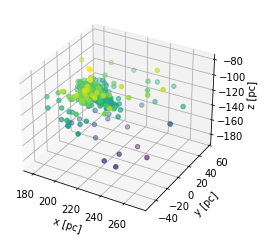

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(blanco_1_cart_coords[0], blanco_1_cart_coords[1], blanco_1_cart_coords[2], 
c=blanco_1_cart_coords[2], cmap='viridis')
ax.scatter3D(blanco_1_cart_center_coords[0], blanco_1_cart_center_coords[1], blanco_1_cart_center_coords[2])

ax.set_xlabel('x [pc]')
ax.set_ylabel('y [pc]')
ax.set_zlabel('z [pc]')

## fit different functions

In [7]:
#the profile functions

def Kings_profile(r, rho_0, r_c, r_t):
    rho_k = rho_0 * (((1 + (r / r_c) ** 2) ** -0.5 - (1 + (r_t / r_c) ** 2) ** -0.5) ** 2)
    return rho_k

def Plummers_profile(r, rho_0, a):
    rho_P = rho_0 * ((1 + ((r / a) ** 2)) ** 2)
    return rho_P

def Zhao_profile(r, rho_0, a, beta):
    rho = rho_0 * ((r / a) ** -1) * ((1 + (r / a) ** 2) ** ((1 - beta) / 2))
    return rho

## CDF

In [8]:
CDF_x = np.sort(d.value)
CDF = np.arange(1, len(d) + 1) / len(d)  #normalised CDF

## error in CDF calculation (MC error propagation)

In [31]:
d_d = lambda plx, eplx: (1000)*((1/plx)**2.*(eplx))
np.random.seed(None)
#distance in pc 
dist = 1000/OC_df['plx']
#distance errors
dist_err = d_d(OC_df['plx'], OC_df['e_plx'])

#number of realisations of the CDF
N=100

CDF_many = np.zeros((len(OC_df['RA_ICRS']),N))
CDF_x_many = np.zeros((len(OC_df['RA_ICRS']),N))


#Setting defaults for centre at function definition
def make_a_CDF(ra, dec, distance, era, edec, edist, centra, centdec,
               centdist, ecentdist):
    dist_draw = []
    ra_draw   = []
    dec_draw  = []
    #Uncomment code to include error in cluster centre
    #centra_draw = [] 
    #centdec_draw = []
    centdist_draw = []
    for i in range(len(ra)):
        dist_draw.append(np.random.normal(distance[i], edist[i], size=1)[0])
        ra_draw.append(np.random.normal(ra[i], era[i], size=1)[0])
        dec_draw.append(np.random.normal(dec[i], edec[i], size=1)[0])
        #print(dist_draw, ra_draw, dec_draw)
        #Uncomment to include error in cluster
        #centra_draw.append(np.random.normal(centra, ecentra, size=1)[0])
        #centdec_draw.append(np.random.normal(centdec, ecentdec, size=1)[0])
        #centdist_draw.append(np.random.normal(centdist, ecentdist, size=1)[0])
#     print(ra_draw)

    try1= SkyCoord(ra=ra_draw*u.degree, dec=dec_draw*u.degree, distance=dist_draw*u.Parcsec, frame='icrs')
    try1 = try1.cartesian.x,try1.cartesian.y,try1.cartesian.z
    tryc1= SkyCoord(ra=centra*u.degree, dec=centdec*u.degree, distance=centdist*u.Parcsec, frame='icrs')
    tryc1 = tryc1.cartesian.x,tryc1.cartesian.y,tryc1.cartesian.z



    #getting the distance of stars from the center of clusters
    def dist(x1,y1,x2,y2):
        return ((x2-x1)**2+(y2-y1)**2)**0.5

    dtry1 = dist(tryc1[0],tryc1[1],
             try1[0],try1[1])

    CDF_x_try1 = np.sort(dtry1.value)
    CDFtry1 = np.arange(1, len(dtry1) + 1) / len(dtry1)  #normalised CDF
    
    return CDF_x_try1, CDFtry1


CDF_err = []

#Loop over the number of realisations we want to create
for i in range(N):
    CDF_x_many[:,i], CDF_many[:,i] = make_a_CDF(OC_df['RA_ICRS'], OC_df['DE_ICRS'], dist, 
                                      OC_df['e_RA_ICRS'], OC_df['e_DE_ICRS'], dist_err,
                                               OC_tb1_df['RA_ICRS'], OC_tb1_df['DE_ICRS'],
                                                1000/OC_tb1_df['plx'],d_d(OC_tb1_df['plx'], OC_tb1_df['s_plx']))
    
#Uncomment to plot realisations.
#     plt.plot(CDF_x_many[:,i], CDF_many[:,i], alpha=0.05, c="red")
    
# for each data point compute the standard devation of all the realisations at that value of x
for k in range(N):
        
    CDF_interp_func = scipy.interpolate.interp1d(CDF_x_many[:,k],CDF_many[:,k], fill_value="extrapolate")
    CDF_err.append(CDF_interp_func(CDF_x))
            
actual_errors = np.std(np.array(CDF_err), axis=0)


## Symbolic CDF

$$
\log{likelihood} = -0.5 * \left( \frac{(expected - observed)^2}{\sigma^2} + \log{\sigma^2} \right)
$$

In [32]:
def cdf_gen(profile='Kings'): 

    if profile=='Kings':
    #getting the cdf from the pdf
        rho_0, r_c, r_t, r = sympy.symbols('rho_0 r_c r_t r')   #defines symbols which want to use in our eqn
        pdf = Kings_profile(r, rho_0, r_c, r_t)                 #defining the pdf
        cdf = sympy.integrate(pdf, r)                           #does the integration to get the CDF from the PDF
        cdf_fxn = sympy.utilities.lambdify([r, rho_0, r_c, r_t], cdf)

    elif profile=='Plummers':
        rho_0, a, r = sympy.symbols('rho_0 a r')
        pdf = Plummers_profile(r, rho_0, a)                
        cdf = sympy.integrate(pdf, r)
        cdf_fxn = sympy.utilities.lambdify([r, rho_0, a], cdf)

    elif profile=='Zhao':
        r, rho_0, a, beta = sympy.symbols('r rho_0 a beta')
        pdf = Zhao_profile(r, rho_0, a)                
        cdf = sympy.integrate(pdf, r)
        cdf_fxn = sympy.utilities.lambdify([r, rho_0, a, beta], cdf)
       
    else:
        print('Please choose a profile between Kings, Plummer or Zhao')
        
    return cdf_fxn

def log_likelihood(theta,x,y,y_err,cdf_model):
    model = cdf_model(x, *theta)
    sigma2 = y_err ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2)) #neg. chi-sq. + nuisance param

def mle(init_guess,x,y,y_err,cdf_model):

    #getting the args for minimise function
    nll = lambda *args: -log_likelihood(*args)
    
    #finding solution by minimise alogorithm
    soln = minimize(nll, init_guess, args=(x, y, y_err, cdf_model), options={'maxfev':1e5}) #args = (x,y,yerr,cdf_function)

    return soln


Maximum likelihood estimates:
rho_0 = 0.092
r_c = 7.342
r_t = 82265.840


/tmp/ipykernel_13482/3094197471.py:38: OptimizeWarning: Unknown solver options: maxfev
  soln = minimize(nll, init_guess, args=(x, y, y_err, cdf_model), options={'maxfev':1e5}) #args = (x,y,yerr,cdf_function)


Text(0, 0.5, 'y')

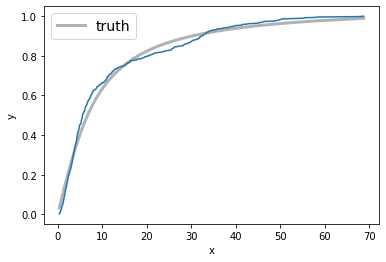

In [35]:
#err array 
np.random.seed(42)
yerr  = np.array(actual_errors) #np.random.normal(size=len(CDF)) / 1e10

#getting cdf
cdf_fxn = cdf_gen(profile='Kings')

#inital_guess - change according to the profile you choose
init_kings = np.array([1.0, np.mean(d.value), 4 * np.mean(d.value)]) #rho_0, r_c, r_t

#getting x and y
CDF_x = np.sort(d.value)                    # x  #basically the r in the profile functions             
CDF = np.arange(1, len(d) + 1) / len(d)     # y  #normalised CDF  

#finding solution by minimise alogorithm
soln = mle(init_guess=init_kings,
            x=CDF_x,
            y=CDF,
            y_err = yerr,
            cdf_model = cdf_fxn)


rho0_ml, rc_ml, rt_ml = soln.x
print("Maximum likelihood estimates:")
print("rho_0 = {0:.3f}".format(rho0_ml))
print("r_c = {0:.3f}".format(rc_ml))
print("r_t = {0:.3f}".format(rt_ml))

plt.plot(CDF_x, cdf_fxn(CDF_x, *soln.x), "k", alpha=0.3, lw=3, label="truth")
plt.plot(CDF_x, CDF)
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y")

ValueError: x and y must be the same size

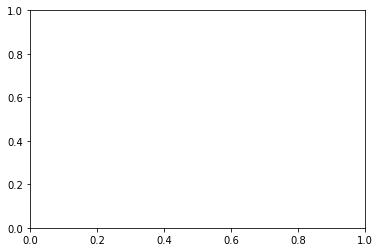

In [36]:
# plt.scatter(CDF_x, CDF_err)

## compare models

## HOORAY!!!